# Using neural networks as a function approximator for estimating the future corona cases

This notebook implements a time series estimation of the corona cases, in order to make prediction of the corona case number in the near future.

Import PyTorch

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Import the dataset

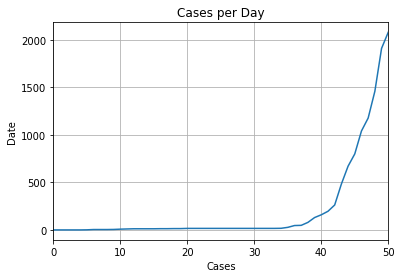

In [2]:
# create a map, that maps the date strings to numbers, which can be inserted in a tensor
date_map = ["1/22/20", "1/23/20", "1/24/20", "1/25/20", "1/26/20", "1/27/20", "1/28/20", "1/29/20", "1/30/20", "1/31/20", "2/1/20", "2/2/20", "2/3/20", "2/4/20", "2/5/20", "2/6/20", "2/7/20", "2/8/20", "2/9/20", "2/10/20", "2/11/20", "2/12/20", "2/13/20", "2/14/20", "2/15/20", "2/16/20", "2/17/20", "2/18/20", "2/19/20", "2/20/20", "2/21/20", "2/22/20", "2/23/20", "2/24/20", "2/25/20", "2/26/20", "2/27/20", "2/28/20", "2/29/20", "3/1/20", "3/2/20", "3/3/20", "3/4/20", "3/5/20", "3/6/20", "3/7/20", "3/8/20", "3/9/20", "3/10/20", "3/11/20", "3/12/20"]

data = pd.read_csv (r'corona_dataset.csv')   #read the csv file (put 'r' before the path string to address any special characters in the path, such as '\'). Don't forget to put the file name at the end of the path + ".csv"
df = pd.DataFrame(data) # here we can do some additional filtering (maybe later :D)

dataArray = [] # an array to hold the data

for date in date_map: # iterate through the data
    dataArray.append(df[date][11]) # append the data to the array

dataTensor = torch.tensor(dataArray) # create the tensor from the array

# plot the graph
plt.title('Cases per Day')
plt.ylabel('Date')
plt.xlabel('Cases')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(dataArray)

Devide the dataset in a test and train dataset

In [3]:
test_data_size = 6

train_data = torch.tensor(dataArray[:-test_data_size])
test_data = torch.tensor(dataArray[-test_data_size:])

Normalize the data with min/max scaling.

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

Create the final training data, by pasting the normalized data into a float tensor.

In [5]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

Create a sequences of 12 days.

In [6]:
train_window = 12 # the sequence length

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

Next up, we will create a Long Short Time Memory Neural Network (LSTM), used to predict our time serieses.

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [8]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Train the model for n epochs

In [9]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 2.75978255
epoch:  26 loss: 0.00055226
epoch:  51 loss: 0.02044726
epoch:  76 loss: 0.01297409
epoch: 101 loss: 0.01771413
epoch: 126 loss: 0.00567036
epoch: 149 loss: 0.0155652734


Make predictions based on the current model

In [14]:
fut_pred = 12
test_inputs = train_data_normalized[-train_window:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

Retrieve the actual numbers

In [15]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1)) 

Create the x axis for the plot

In [16]:
x = np.arange(len(dataArray)-5, len(dataArray) + len(actual_predictions) -5, 1)

Plot the results

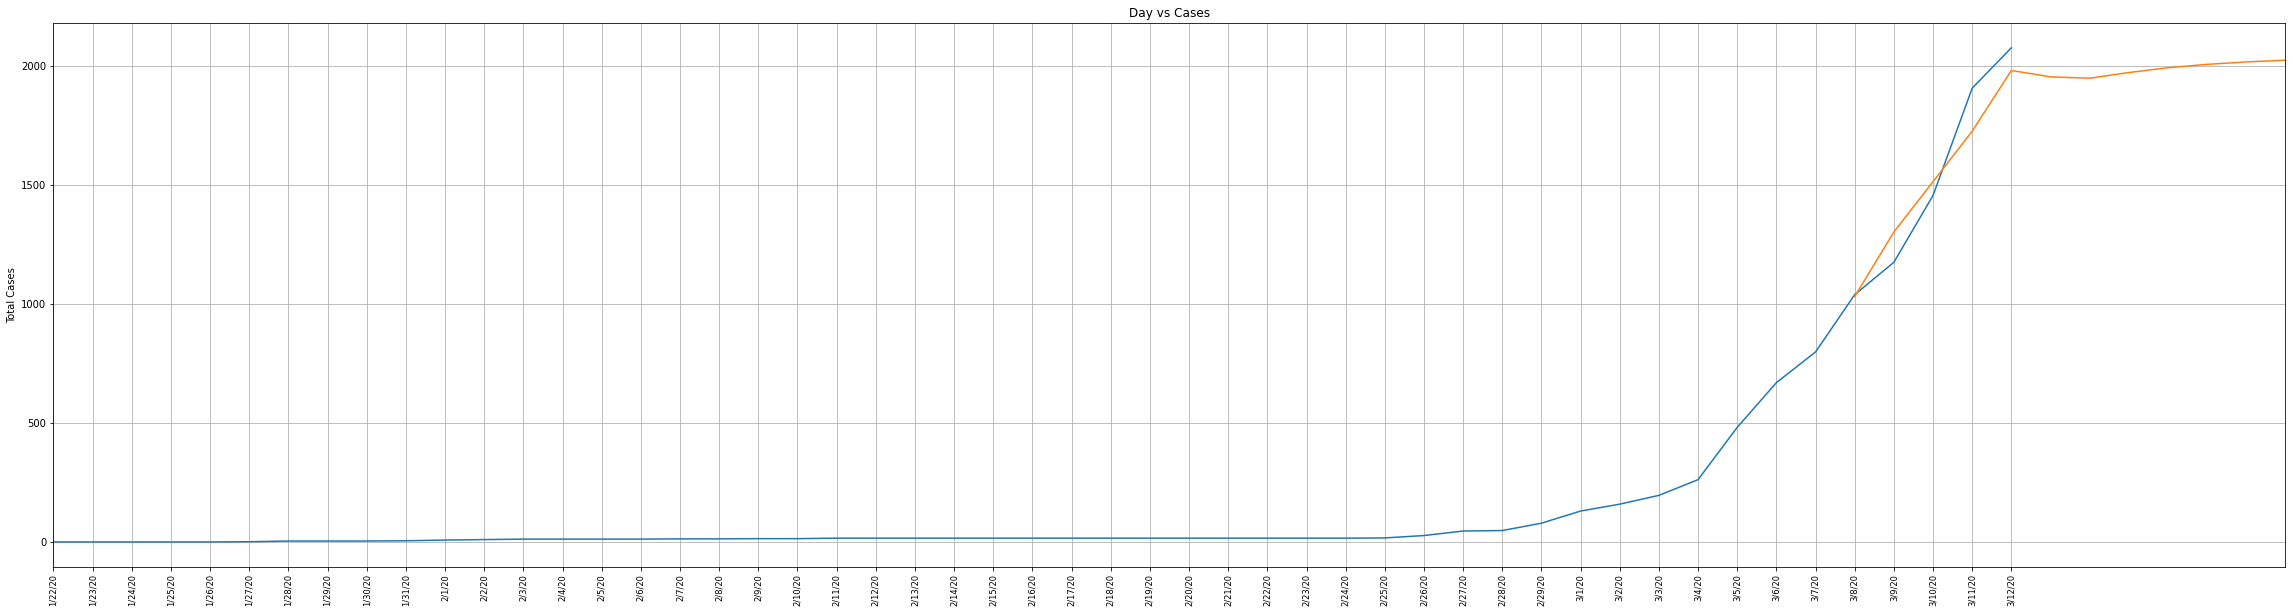

In [17]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 40
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

plt.title('Day vs Cases')
plt.ylabel('Total Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(dataArray)
plt.plot(x,actual_predictions)
plt.xticks(range(len(date_map)), date_map, size='small', rotation="vertical")
plt.show()

## Conclusion

Although the plottet Graph looks weird in the end, which is probably due to the lack of samples, the LSTM model did a great job approximating the function.
I will rerun this notebook every week or so, to tackle the problem of the lack of sample data. This model should improve over time.